In [21]:
import pandas as pd 

df = pd.read_csv('data/abalone.csv')
df.head()

,Sex,Length,Diameter,Height,Whole,Shucked,Viscera,Shell,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [22]:
target = 'Rings'
cont_cols = [col for col in df.columns if col != 'Rings' and col != 'Sex']
X_cols = df.columns.to_list()
X_cols.remove(target)
X_cols, target

(['Sex',
  'Length',
  'Diameter',
  'Height',
  'Whole',
  'Shucked',
  'Viscera',
  'Shell'],
 'Rings')

In [23]:
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor

ct = ColumnTransformer([
    ('std', 'passthrough', cont_cols), # 연속형 변수들
    ('ohe', OneHotEncoder(drop='first'), ['Sex']) # 범주형은 가변수화
])

reg_sgd_lr = make_pipeline(ct, SGDRegressor(max_iter=100))
reg_sgd_lr.fit(df[X_cols], df[target])
mean_squared_error(reg_sgd_lr.predict(df[X_cols]), df[target])

C:\Users\xptr3\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


5.310627408720858

In [45]:
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor

ct = ColumnTransformer([
    ('std', StandardScaler(), cont_cols), # 연속형 변수들 표준화
    ('ohe', OneHotEncoder(drop='first'), ['Sex']) # 범주형은 가변수화
])

X_ct_cols = [col + '_std' for col in cont_cols] + ['Sex_I'] + ['Sex_M']

reg_sgd_lr = make_pipeline(ct, SGDRegressor(max_iter=100))
reg_sgd_lr.fit(df[X_cols], df[target])
mean_squared_error(reg_sgd_lr.predict(df[X_cols]), df[target])

4.861232015972581

In [46]:
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split

ct = ColumnTransformer([
    ('std', StandardScaler(), cont_cols), # 연속형 변수들 표준화
    ('ohe', OneHotEncoder(drop='first'), ['Sex']) # 범주형은 가변수화
])

df_train, df_test = train_test_split(df, train_size=0.8, random_state=123)
df_train.size, df_test.size

(30069, 7524)

In [47]:
# do the ridge regression 

from sklearn.linear_model import Ridge

alphas = [1e-2, 1e-1, 1, 1e1, 1e2, 1e3]

coefs = []
mse_test = []
for alpha in alphas:
    model = make_pipeline(ct, Ridge(alpha=alpha, random_state=123))
    model.fit(df_train[X_cols], df_train[target])
    coefs.append(model[1].coef_)
    mse_test.append(mean_squared_error(df_test[target], model.predict(df_test[X_cols])))

In [48]:
X_ct_cols

['Length_std',
 'Diameter_std',
 'Height_std',
 'Whole_std',
 'Shucked_std',
 'Viscera_std',
 'Shell_std',
 'Sex_I',
 'Sex_M']

In [71]:
df_coef = pd.DataFrame(coefs, index=pd.Index(alphas, name='alpha'), columns=X_ct_cols).reset_index().melt(id_vars='alpha', var_name='feature', value_name='coef')

In [72]:
#df_before = pd.pivot_table(df_coef, index='alpha', columns='feature', values='coef')
#df_before

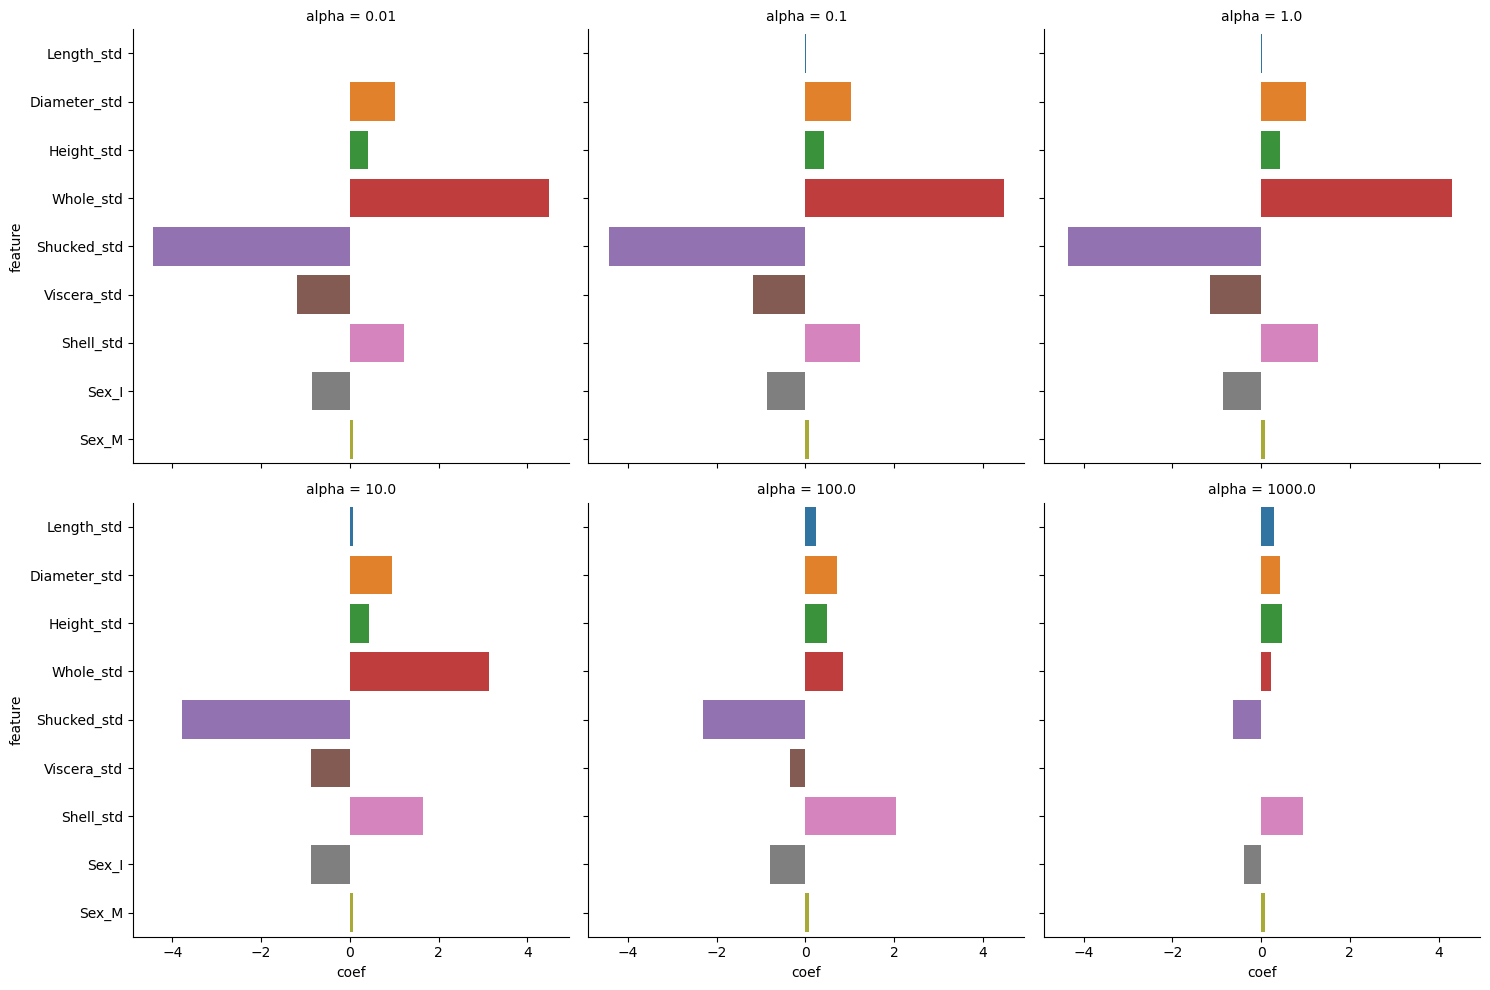

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt 
sns.catplot(data=df_coef, y='feature', x='coef', col='alpha', col_wrap=3, kind='bar')
plt.show()

In [70]:
import numpy as np
coefs[np.argmin(mse_test)]

array([ 0.02214071,  1.01467699,  0.41840584,  4.30184074, -4.35663264,
       -1.14918372,  1.28912936, -0.86118244,  0.07999575])

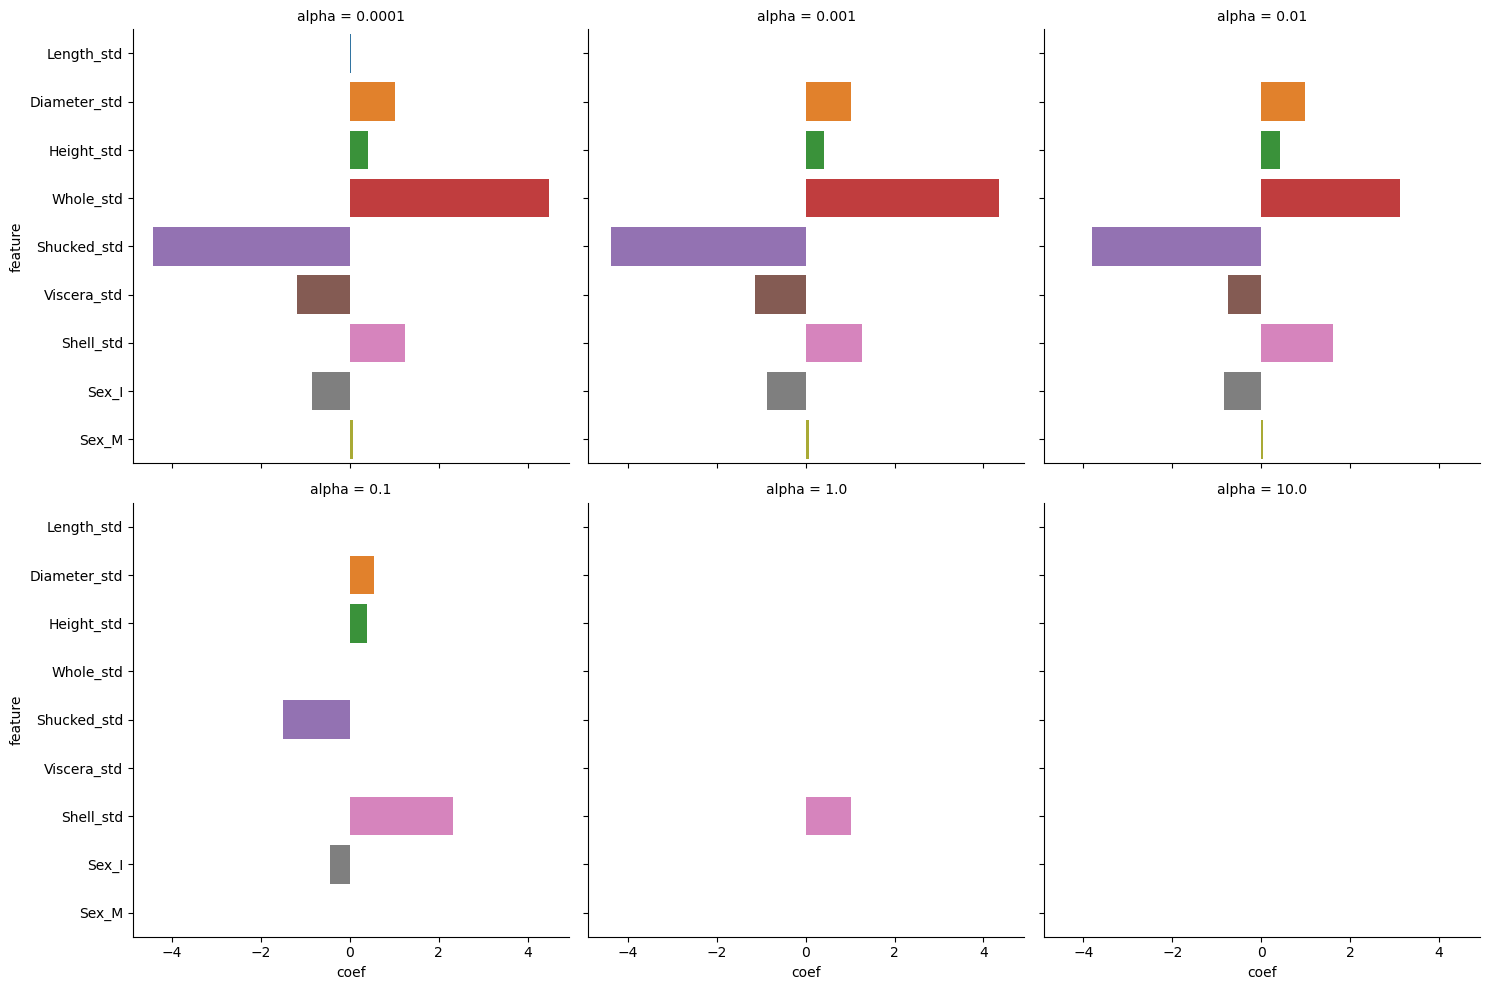

In [76]:
# do the lasso regression

from sklearn.linear_model import Lasso
import seaborn as sns 

alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]

coefs = []
mse_test = []
for alpha in alphas:
    model = make_pipeline(ct, Lasso(alpha=alpha, random_state=123))
    model.fit(df_train[X_cols], df_train[target])
    coefs.append(model[1].coef_)
    mse_test.append(mean_squared_error(df_test[target], model.predict(df_test[X_cols])))
    
df_coef = pd.DataFrame(coefs, index=pd.Index(alphas, name='alpha'), columns=X_ct_cols).reset_index().melt(id_vars='alpha', var_name='feature', value_name='coef')
sns.catplot(data=df_coef, y='feature', x='coef', col='alpha', col_wrap=3, kind='bar')
plt.show()

In [77]:
alphas[np.argmin(mse_test)]

0.01

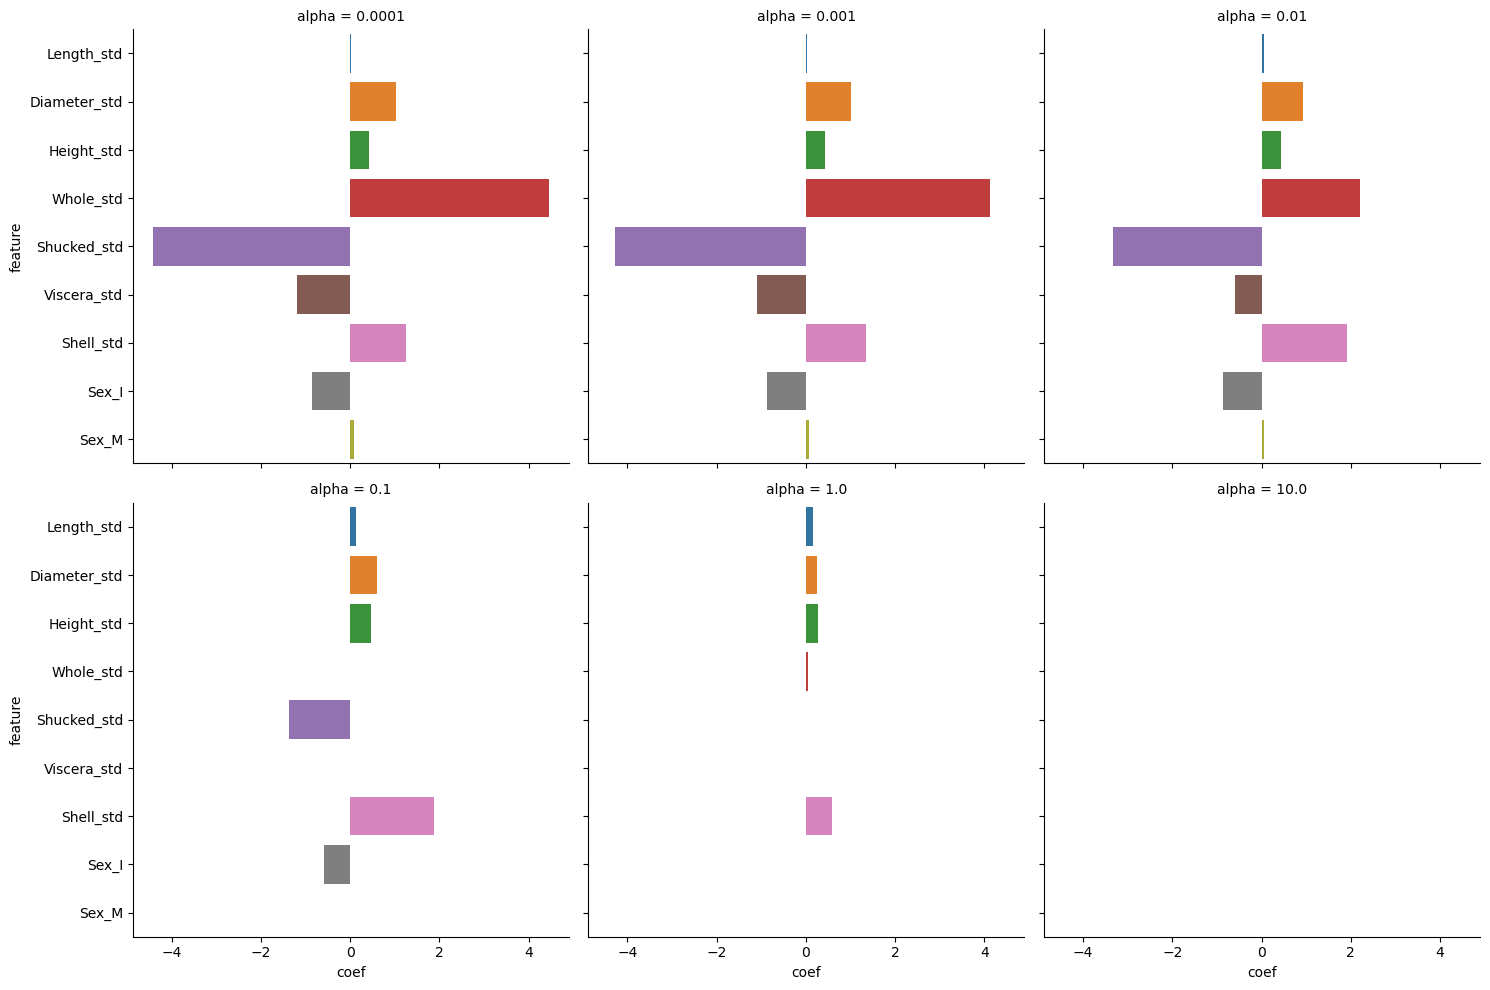

In [79]:
# Use ElasticNet

from sklearn.linear_model import ElasticNet
import seaborn as sns 

alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]

coefs = []
mse_test = []
for alpha in alphas:
    model = make_pipeline(ct, ElasticNet(alpha=alpha, random_state=123))
    model.fit(df_train[X_cols], df_train[target])
    coefs.append(model[1].coef_)
    mse_test.append(mean_squared_error(df_test[target], model.predict(df_test[X_cols])))
    
df_coef = pd.DataFrame(coefs, index=pd.Index(alphas, name='alpha'), columns=X_ct_cols).reset_index().melt(id_vars='alpha', var_name='feature', value_name='coef')
sns.catplot(data=df_coef, y='feature', x='coef', col='alpha', col_wrap=3, kind='bar')
plt.show()

In [80]:
alphas[np.argmin(mse_test)]

0.001

## Binary Classification

In [83]:
df_train = df_train[df_train['Sex'].isin(['F', 'M'])]
df_test = df_test[df_test['Sex'].isin(['F', 'M'])]
df_train.size, df_test.size

(20511, 5004)

In [86]:
X_cols = df_train.columns.drop('Sex').to_list()
X_cols

['Length',
 'Diameter',
 'Height',
 'Whole',
 'Shucked',
 'Viscera',
 'Shell',
 'Rings']

In [92]:
from sklearn.linear_model import LogisticRegression 

model = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=123, solver='lbfgs')
)

model.fit(df_train[X_cols], df_train['Sex'])
probs = model.predict_proba(df_test[X_cols])
probs = probs[:, 1]

In [93]:
from sklearn.metrics import roc_auc_score

roc_auc_score(df_test['Sex'], probs)

0.558851397589093

In [94]:
from sklearn.linear_model import LogisticRegression 

params = [1e-2, 1e-1, 1, 1e1, 1e2]

roc_test = []
for param in params:
    model = make_pipeline(
        StandardScaler(),
        LogisticRegression(C=param, random_state=123, solver='lbfgs')
    )

    model.fit(df_train[X_cols], df_train['Sex'])
    probs = model.predict_proba(df_test[X_cols])
    probs = probs[:, 1]
    roc_test.append(roc_auc_score(df_test['Sex'], probs))
    
params[np.argmin(roc_test)]

0.01

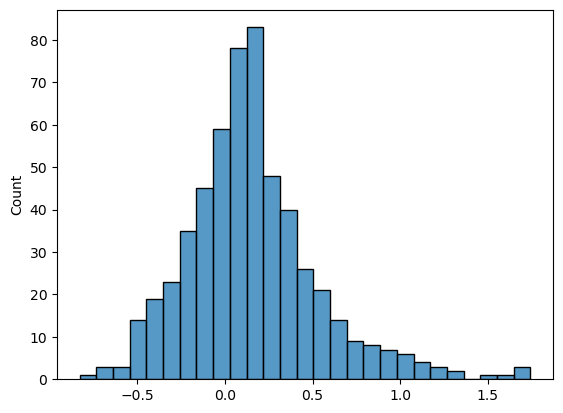

In [96]:
sns.histplot(
    model.decision_function(df_test[X_cols]) # Logit 값을 얻을 수 있음
)
plt.show()

In [97]:
import pandas as pd 

df = pd.read_csv('data/abalone.csv')
df_train, df_test = train_test_split(df, train_size=0.8, random_state=123)
df_train.size, df_test.size

(30069, 7524)

In [98]:
df_train['Sex'].value_counts()

M    1214
F    1065
I    1062
Name: Sex, dtype: int64

In [99]:
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=123, solver='lbfgs', multi_class='ovr')
)
model.fit(df_train[X_cols], df_train['Sex'])
model[1].coef_, model[1].intercept_

(array([[-0.01289247,  1.0203668 ,  0.23410588,  0.15956636, -0.7117244 ,
          0.39013469, -0.23430952,  0.1573919 ],
        [ 1.8503066 , -0.7713847 , -0.2266418 , -1.74907003,  0.15134294,
         -1.48124379,  0.304532  , -0.66902424],
        [-0.20892971,  0.3043963 ,  0.03182928, -0.1664884 ,  0.58584343,
          0.083093  , -0.21802962,  0.26162426]]),
 array([-0.93339435, -1.59994996, -0.6009166 ]))

multi_class를 ovr로 할 경우에는 'F', 'I', 'M' 클래스를 차례대로 positive class로 만들어 로지스틱 회귀모델 이진 분류 3개를 만듭니다.
그리고 Positive 확률이 가장 큰 클래스로 예측합니다.

In [ ]:
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=123, solver='lbfgs', multi_class='ovr')
)
model.fit(df_train[X_cols], df_train['Sex'])
model[1].coef_, model[1].intercept_

In [100]:
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=123, solver='lbfgs')
)
for i in ['F', 'I', 'M']:
    model.fit(df_train[X_cols], df_train['Sex']==i)
    print(i, model[1].coef_, model[1].intercept_)

F [[-0.01289247  1.0203668   0.23410588  0.15956636 -0.7117244   0.39013469
  -0.23430952  0.1573919 ]] [-0.93339435]
I [[ 1.8503066  -0.7713847  -0.2266418  -1.74907003  0.15134294 -1.48124379
   0.304532   -0.66902424]] [-1.59994996]
M [[-0.20892971  0.3043963   0.03182928 -0.1664884   0.58584343  0.083093
  -0.21802962  0.26162426]] [-0.6009166]


multi_class를 multinomial일 경우에는 softmax로 손실을 계산하는 로지스틱 회귀 모델을 만듭니다

In [101]:
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=123, solver='lbfgs', multi_class='multinomial')
)
model.fit(df_train[X_cols], df_train['Sex'])
model[1].coef_, model[1].intercept_

(array([[-0.55597341,  0.57213952,  0.14144636,  0.73018788, -0.46457491,
          0.5751959 , -0.175952  ,  0.21029227],
        [ 1.25691352, -0.61626288, -0.16678387, -1.30535756,  0.21177478,
         -0.97403424,  0.29214273, -0.44814125],
        [-0.70094011,  0.04412336,  0.02533751,  0.57516967,  0.25280013,
          0.39883834, -0.11619073,  0.23784898]]),
 array([ 0.15546789, -0.58741748,  0.43194959]))

one-vs-rest(OVR)과 multinomial 비교
- OVR에서는 각 평면들이 교차하는 영역에서의 부정확한 경계가 만들어질 수 있고, 이러한 문제는 클래스의 분포가 불균형할 때 심하게 나타납니다.
- 반면, OVR은 multinomial에 비해 직관적이며 해석이 용이합니다.